# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 pre-selected sign-adjusted topics (BCC) (out of 200 topics estimated on articles published before 2010 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 pre-selected sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'              # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11838
EM iteration 50, llf=-11670, convergence criterion=1.1907e-06
EM converged at iteration 55, llf=-11670, convergence criterion=9.903e-07 < tolerance=1e-06
EM start iterations, llf=-11850
EM iteration 50, llf=-11681, convergence criterion=1.1898e-06
EM converged at iteration 55, llf=-11681, convergence criterion=9.8944e-07 < tolerance=1e-06
EM start iterations, llf=-11907
EM iteration 50, llf=-11736, convergence criterion=1.1846e-06
EM converged at iteration 55, llf=-11735, convergence criterion=9.8499e-07 < tolerance=1e-06
EM start iterations, llf=-11914
EM iteration 50, llf=-11743, convergence criterion=1.1838e-06
EM converged at iteration 55, llf=-11743, convergence criterion=9.8439e-07 < tolerance=1e-06
EM start iterations, llf=-11981
EM iteration 50, llf=-11808, convergence criterion=1.2133e-06
EM converged at iteration 56, llf=-11808, convergence criterion=9.7388e-07 < tolerance=1e-06
EM start iterations, llf=-11990
EM iteration 50, llf=-11818, conve

EM start iterations, llf=-12738
EM iteration 50, llf=-12601, convergence criterion=1.1004e-06
EM converged at iteration 53, llf=-12601, convergence criterion=9.7987e-07 < tolerance=1e-06
EM start iterations, llf=-12750
EM iteration 50, llf=-12612, convergence criterion=1.0991e-06
EM converged at iteration 53, llf=-12611, convergence criterion=9.7871e-07 < tolerance=1e-06
EM start iterations, llf=-12799
EM converged at iteration 49, llf=-12664, convergence criterion=9.8855e-07 < tolerance=1e-06
EM start iterations, llf=-12810
EM converged at iteration 49, llf=-12675, convergence criterion=9.8693e-07 < tolerance=1e-06
EM start iterations, llf=-12870
EM converged at iteration 49, llf=-12734, convergence criterion=9.8266e-07 < tolerance=1e-06
EM start iterations, llf=-12870
EM converged at iteration 49, llf=-12734, convergence criterion=9.8266e-07 < tolerance=1e-06
EM start iterations, llf=-12879
EM converged at iteration 49, llf=-12741, convergence criterion=9.8447e-07 < tolerance=1e-06
E

EM start iterations, llf=-14437
EM converged at iteration 47, llf=-14286, convergence criterion=9.7505e-07 < tolerance=1e-06
EM start iterations, llf=-14448
EM converged at iteration 47, llf=-14297, convergence criterion=9.7534e-07 < tolerance=1e-06
EM start iterations, llf=-14499
EM converged at iteration 47, llf=-14349, convergence criterion=9.7183e-07 < tolerance=1e-06
EM start iterations, llf=-14499
EM converged at iteration 47, llf=-14349, convergence criterion=9.7183e-07 < tolerance=1e-06
EM start iterations, llf=-14508
EM converged at iteration 47, llf=-14358, convergence criterion=9.7062e-07 < tolerance=1e-06
EM start iterations, llf=-14563
EM converged at iteration 47, llf=-14412, convergence criterion=9.6646e-07 < tolerance=1e-06
EM start iterations, llf=-14572
EM converged at iteration 47, llf=-14422, convergence criterion=9.6456e-07 < tolerance=1e-06
EM start iterations, llf=-14622
EM converged at iteration 46, llf=-14472, convergence criterion=9.766e-07 < tolerance=1e-06
E

EM start iterations, llf=-16180
EM converged at iteration 47, llf=-16021, convergence criterion=9.6847e-07 < tolerance=1e-06
EM start iterations, llf=-16190
EM converged at iteration 47, llf=-16031, convergence criterion=9.6782e-07 < tolerance=1e-06
EM start iterations, llf=-16244
EM converged at iteration 47, llf=-16085, convergence criterion=9.6412e-07 < tolerance=1e-06
EM start iterations, llf=-16253
EM converged at iteration 47, llf=-16094, convergence criterion=9.632e-07 < tolerance=1e-06
EM start iterations, llf=-16304
EM converged at iteration 47, llf=-16145, convergence criterion=9.6143e-07 < tolerance=1e-06
EM start iterations, llf=-16313
EM converged at iteration 47, llf=-16153, convergence criterion=9.6101e-07 < tolerance=1e-06
EM start iterations, llf=-16368
EM converged at iteration 46, llf=-16208, convergence criterion=9.9838e-07 < tolerance=1e-06
EM start iterations, llf=-16368
EM converged at iteration 46, llf=-16208, convergence criterion=9.9838e-07 < tolerance=1e-06
E

EM start iterations, llf=-17470
EM iteration 50, llf=-17299, convergence criterion=1.3472e-06
EM converged at iteration 59, llf=-17299, convergence criterion=9.883e-07 < tolerance=1e-06
EM start iterations, llf=-17470
EM iteration 50, llf=-17299, convergence criterion=1.3472e-06
EM converged at iteration 59, llf=-17299, convergence criterion=9.883e-07 < tolerance=1e-06
EM start iterations, llf=-17489
EM iteration 50, llf=-17318, convergence criterion=1.3457e-06
EM converged at iteration 59, llf=-17318, convergence criterion=9.8718e-07 < tolerance=1e-06
EM start iterations, llf=-17544
EM iteration 50, llf=-17373, convergence criterion=1.341e-06
EM converged at iteration 59, llf=-17372, convergence criterion=9.8379e-07 < tolerance=1e-06
EM start iterations, llf=-17552
EM iteration 50, llf=-17381, convergence criterion=1.34e-06
EM converged at iteration 59, llf=-17381, convergence criterion=9.8303e-07 < tolerance=1e-06
EM start iterations, llf=-17599
EM iteration 50, llf=-17427, convergen

EM start iterations, llf=-18400
EM iteration 50, llf=-18228, convergence criterion=1.3606e-06
EM converged at iteration 59, llf=-18227, convergence criterion=9.9881e-07 < tolerance=1e-06
EM start iterations, llf=-18451
EM iteration 50, llf=-18278, convergence criterion=1.3575e-06
EM converged at iteration 59, llf=-18278, convergence criterion=9.9643e-07 < tolerance=1e-06
EM start iterations, llf=-18458
EM iteration 50, llf=-18285, convergence criterion=1.357e-06
EM converged at iteration 59, llf=-18285, convergence criterion=9.9605e-07 < tolerance=1e-06
EM start iterations, llf=-18515
EM iteration 50, llf=-18341, convergence criterion=1.356e-06
EM converged at iteration 59, llf=-18341, convergence criterion=9.9539e-07 < tolerance=1e-06
EM start iterations, llf=-18522
EM iteration 50, llf=-18348, convergence criterion=1.3555e-06
EM converged at iteration 59, llf=-18348, convergence criterion=9.9507e-07 < tolerance=1e-06
EM start iterations, llf=-18578
EM iteration 50, llf=-18403, conver

EM converged at iteration 56, llf=-11732, convergence criterion=9.7105e-07 < tolerance=1e-06
EM start iterations, llf=-11914
EM iteration 50, llf=-11739, convergence criterion=1.2101e-06
EM converged at iteration 56, llf=-11739, convergence criterion=9.7038e-07 < tolerance=1e-06
EM start iterations, llf=-11981
EM iteration 50, llf=-11804, convergence criterion=1.2448e-06
EM converged at iteration 56, llf=-11804, convergence criterion=9.9747e-07 < tolerance=1e-06
EM start iterations, llf=-11990
EM iteration 50, llf=-11814, convergence criterion=1.2439e-06
EM converged at iteration 56, llf=-11813, convergence criterion=9.9668e-07 < tolerance=1e-06
EM start iterations, llf=-12047
EM iteration 50, llf=-11873, convergence criterion=1.2288e-06
EM converged at iteration 56, llf=-11873, convergence criterion=9.8547e-07 < tolerance=1e-06
EM start iterations, llf=-12047
EM iteration 50, llf=-11873, convergence criterion=1.2288e-06
EM converged at iteration 56, llf=-11873, convergence criterion=9

EM converged at iteration 54, llf=-12662, convergence criterion=9.7947e-07 < tolerance=1e-06
EM start iterations, llf=-12810
EM iteration 50, llf=-12673, convergence criterion=1.1287e-06
EM converged at iteration 54, llf=-12672, convergence criterion=9.755e-07 < tolerance=1e-06
EM start iterations, llf=-12870
EM iteration 50, llf=-12733, convergence criterion=1.0897e-06
EM converged at iteration 53, llf=-12732, convergence criterion=9.7609e-07 < tolerance=1e-06
EM start iterations, llf=-12870
EM iteration 50, llf=-12733, convergence criterion=1.0897e-06
EM converged at iteration 53, llf=-12732, convergence criterion=9.7609e-07 < tolerance=1e-06
EM start iterations, llf=-12879
EM iteration 50, llf=-12740, convergence criterion=1.0907e-06
EM converged at iteration 53, llf=-12740, convergence criterion=9.7705e-07 < tolerance=1e-06
EM start iterations, llf=-12936
EM iteration 50, llf=-12797, convergence criterion=1.0613e-06
EM converged at iteration 52, llf=-12797, convergence criterion=9.

EM start iterations, llf=-14261
EM converged at iteration 48, llf=-14120, convergence criterion=9.8478e-07 < tolerance=1e-06
EM start iterations, llf=-14300
EM converged at iteration 48, llf=-14155, convergence criterion=9.9272e-07 < tolerance=1e-06
EM start iterations, llf=-14300
EM converged at iteration 48, llf=-14155, convergence criterion=9.9272e-07 < tolerance=1e-06
EM start iterations, llf=-14310
EM converged at iteration 48, llf=-14162, convergence criterion=9.9013e-07 < tolerance=1e-06
EM start iterations, llf=-14381
EM converged at iteration 48, llf=-14229, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-14387
EM converged at iteration 48, llf=-14236, convergence criterion=9.7573e-07 < tolerance=1e-06
EM start iterations, llf=-14437
EM converged at iteration 47, llf=-14286, convergence criterion=9.9949e-07 < tolerance=1e-06
EM start iterations, llf=-14448
EM converged at iteration 48, llf=-14297, convergence criterion=9.6096e-07 < tolerance=1e-06


EM start iterations, llf=-15999
EM converged at iteration 48, llf=-15840, convergence criterion=9.657e-07 < tolerance=1e-06
EM start iterations, llf=-16054
EM converged at iteration 48, llf=-15895, convergence criterion=9.6559e-07 < tolerance=1e-06
EM start iterations, llf=-16059
EM converged at iteration 48, llf=-15899, convergence criterion=9.6585e-07 < tolerance=1e-06
EM start iterations, llf=-16117
EM converged at iteration 48, llf=-15956, convergence criterion=9.7663e-07 < tolerance=1e-06
EM start iterations, llf=-16122
EM converged at iteration 48, llf=-15962, convergence criterion=9.781e-07 < tolerance=1e-06
EM start iterations, llf=-16180
EM converged at iteration 48, llf=-16020, convergence criterion=9.7231e-07 < tolerance=1e-06
EM start iterations, llf=-16180
EM converged at iteration 48, llf=-16020, convergence criterion=9.7231e-07 < tolerance=1e-06
EM start iterations, llf=-16190
EM converged at iteration 48, llf=-16030, convergence criterion=9.7257e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17353
EM iteration 50, llf=-17182, convergence criterion=1.3753e-06
EM converged at iteration 60, llf=-17182, convergence criterion=9.8528e-07 < tolerance=1e-06
EM start iterations, llf=-17358
EM iteration 50, llf=-17187, convergence criterion=1.3744e-06
EM converged at iteration 60, llf=-17187, convergence criterion=9.8461e-07 < tolerance=1e-06
EM start iterations, llf=-17413
EM iteration 50, llf=-17242, convergence criterion=1.3857e-06
EM converged at iteration 60, llf=-17242, convergence criterion=9.9301e-07 < tolerance=1e-06
EM start iterations, llf=-17422
EM iteration 50, llf=-17250, convergence criterion=1.3863e-06
EM converged at iteration 60, llf=-17250, convergence criterion=9.9355e-07 < tolerance=1e-06
EM start iterations, llf=-17470
EM iteration 50, llf=-17298, convergence criterion=1.3816e-06
EM converged at iteration 60, llf=-17298, convergence criterion=9.9009e-07 < tolerance=1e-06
EM start iterations, llf=-17470
EM iteration 50, llf=-17298, conv

EM start iterations, llf=-18331
EM iteration 50, llf=-18158, convergence criterion=1.3832e-06
EM converged at iteration 60, llf=-18158, convergence criterion=9.8882e-07 < tolerance=1e-06
EM start iterations, llf=-18336
EM iteration 50, llf=-18163, convergence criterion=1.3835e-06
EM converged at iteration 60, llf=-18163, convergence criterion=9.8903e-07 < tolerance=1e-06
EM start iterations, llf=-18395
EM iteration 50, llf=-18221, convergence criterion=1.3743e-06
EM converged at iteration 60, llf=-18221, convergence criterion=9.8194e-07 < tolerance=1e-06
EM start iterations, llf=-18395
EM iteration 50, llf=-18221, convergence criterion=1.3743e-06
EM converged at iteration 60, llf=-18221, convergence criterion=9.8194e-07 < tolerance=1e-06
EM start iterations, llf=-18400
EM iteration 50, llf=-18227, convergence criterion=1.3744e-06
EM converged at iteration 60, llf=-18227, convergence criterion=9.8209e-07 < tolerance=1e-06
EM start iterations, llf=-18452
EM iteration 50, llf=-18277, conv

EM start iterations, llf=-19214
EM iteration 50, llf=-19037, convergence criterion=1.3802e-06
EM converged at iteration 60, llf=-19036, convergence criterion=9.8591e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 2 estimated in 1:40:27.473450.
EM start iterations, llf=-11830
EM iteration 50, llf=-11658, convergence criterion=1.3171e-06
EM converged at iteration 58, llf=-11658, convergence criterion=9.7814e-07 < tolerance=1e-06
EM start iterations, llf=-11842
EM iteration 50, llf=-11669, convergence criterion=1.3178e-06
EM converged at iteration 58, llf=-11669, convergence criterion=9.7831e-07 < tolerance=1e-06
EM start iterations, llf=-11899
EM iteration 50, llf=-11725, convergence criterion=1.3132e-06
EM converged at iteration 58, llf=-11724, convergence criterion=9.7448e-07 < tolerance=1e-06
EM start iterations, llf=-11906
EM iteration 50, llf=-11732, convergence criterion=1.3123e-06
EM converged at iteration 58, llf=-11732, convergence criterion=9.7385e-07 < toleranc

EM converged at iteration 74, llf=-12534, convergence criterion=9.8263e-07 < tolerance=1e-06
EM start iterations, llf=-12684
EM iteration 50, llf=-12546, convergence criterion=1.8302e-06
EM converged at iteration 74, llf=-12546, convergence criterion=9.9223e-07 < tolerance=1e-06
EM start iterations, llf=-12735
EM iteration 50, llf=-12598, convergence criterion=1.7987e-06
EM converged at iteration 74, llf=-12598, convergence criterion=9.8573e-07 < tolerance=1e-06
EM start iterations, llf=-12747
EM iteration 50, llf=-12609, convergence criterion=1.774e-06
EM converged at iteration 75, llf=-12608, convergence criterion=9.8249e-07 < tolerance=1e-06
EM start iterations, llf=-12796
EM iteration 50, llf=-12661, convergence criterion=1.6226e-06
EM converged at iteration 69, llf=-12661, convergence criterion=9.7935e-07 < tolerance=1e-06
EM start iterations, llf=-12807
EM iteration 50, llf=-12672, convergence criterion=1.6107e-06
EM converged at iteration 69, llf=-12672, convergence criterion=9.

EM converged at iteration 56, llf=-13704, convergence criterion=9.7093e-07 < tolerance=1e-06
EM start iterations, llf=-13853
EM iteration 50, llf=-13716, convergence criterion=1.1384e-06
EM converged at iteration 54, llf=-13716, convergence criterion=9.9395e-07 < tolerance=1e-06
EM start iterations, llf=-13879
EM iteration 50, llf=-13745, convergence criterion=1.1416e-06
EM converged at iteration 54, llf=-13745, convergence criterion=9.9878e-07 < tolerance=1e-06
EM start iterations, llf=-13883
EM iteration 50, llf=-13747, convergence criterion=1.1594e-06
EM converged at iteration 55, llf=-13747, convergence criterion=9.8291e-07 < tolerance=1e-06
EM start iterations, llf=-13930
EM iteration 50, llf=-13790, convergence criterion=1.1644e-06
EM converged at iteration 55, llf=-13789, convergence criterion=9.8591e-07 < tolerance=1e-06
EM start iterations, llf=-13930
EM iteration 50, llf=-13790, convergence criterion=1.1644e-06
EM converged at iteration 55, llf=-13789, convergence criterion=9

EM converged at iteration 58, llf=-14830, convergence criterion=9.9849e-07 < tolerance=1e-06
EM start iterations, llf=-14989
EM iteration 50, llf=-14838, convergence criterion=1.2548e-06
EM converged at iteration 58, llf=-14838, convergence criterion=9.9809e-07 < tolerance=1e-06
EM start iterations, llf=-15048
EM iteration 50, llf=-14897, convergence criterion=1.2364e-06
EM converged at iteration 58, llf=-14897, convergence criterion=9.763e-07 < tolerance=1e-06
EM start iterations, llf=-15048
EM iteration 50, llf=-14897, convergence criterion=1.2364e-06
EM converged at iteration 58, llf=-14897, convergence criterion=9.763e-07 < tolerance=1e-06
EM start iterations, llf=-15057
EM iteration 50, llf=-14906, convergence criterion=1.2361e-06
EM converged at iteration 58, llf=-14906, convergence criterion=9.7649e-07 < tolerance=1e-06
EM start iterations, llf=-15110
EM iteration 50, llf=-14959, convergence criterion=1.2446e-06
EM converged at iteration 58, llf=-14959, convergence criterion=9.8

EM converged at iteration 56, llf=-16019, convergence criterion=9.9893e-07 < tolerance=1e-06
EM start iterations, llf=-16175
EM iteration 50, llf=-16019, convergence criterion=1.2095e-06
EM converged at iteration 56, llf=-16019, convergence criterion=9.9893e-07 < tolerance=1e-06
EM start iterations, llf=-16185
EM iteration 50, llf=-16029, convergence criterion=1.2106e-06
EM converged at iteration 57, llf=-16029, convergence criterion=9.7097e-07 < tolerance=1e-06
EM start iterations, llf=-16240
EM iteration 50, llf=-16083, convergence criterion=1.2069e-06
EM converged at iteration 56, llf=-16083, convergence criterion=9.9768e-07 < tolerance=1e-06
EM start iterations, llf=-16248
EM iteration 50, llf=-16092, convergence criterion=1.203e-06
EM converged at iteration 56, llf=-16092, convergence criterion=9.9472e-07 < tolerance=1e-06
EM start iterations, llf=-16300
EM iteration 50, llf=-16143, convergence criterion=1.2001e-06
EM converged at iteration 56, llf=-16143, convergence criterion=9.

EM converged at iteration 67, llf=-17125, convergence criterion=9.8964e-07 < tolerance=1e-06
EM start iterations, llf=-17347
EM iteration 50, llf=-17180, convergence criterion=1.6445e-06
EM converged at iteration 67, llf=-17180, convergence criterion=9.833e-07 < tolerance=1e-06
EM start iterations, llf=-17353
EM iteration 50, llf=-17186, convergence criterion=1.6436e-06
EM converged at iteration 67, llf=-17186, convergence criterion=9.8324e-07 < tolerance=1e-06
EM start iterations, llf=-17408
EM iteration 50, llf=-17241, convergence criterion=1.6548e-06
EM converged at iteration 67, llf=-17240, convergence criterion=9.9087e-07 < tolerance=1e-06
EM start iterations, llf=-17417
EM iteration 50, llf=-17249, convergence criterion=1.6554e-06
EM converged at iteration 67, llf=-17249, convergence criterion=9.9114e-07 < tolerance=1e-06
EM start iterations, llf=-17465
EM iteration 50, llf=-17297, convergence criterion=1.6498e-06
EM converged at iteration 67, llf=-17296, convergence criterion=9.

EM converged at iteration 66, llf=-18098, convergence criterion=9.7753e-07 < tolerance=1e-06
EM start iterations, llf=-18326
EM iteration 50, llf=-18157, convergence criterion=1.6148e-06
EM converged at iteration 66, llf=-18156, convergence criterion=9.8453e-07 < tolerance=1e-06
EM start iterations, llf=-18331
EM iteration 50, llf=-18161, convergence criterion=1.6145e-06
EM converged at iteration 66, llf=-18161, convergence criterion=9.8376e-07 < tolerance=1e-06
EM start iterations, llf=-18389
EM iteration 50, llf=-18220, convergence criterion=1.5973e-06
EM converged at iteration 65, llf=-18219, convergence criterion=9.9809e-07 < tolerance=1e-06
EM start iterations, llf=-18389
EM iteration 50, llf=-18220, convergence criterion=1.5973e-06
EM converged at iteration 65, llf=-18219, convergence criterion=9.9809e-07 < tolerance=1e-06
EM start iterations, llf=-18395
EM iteration 50, llf=-18225, convergence criterion=1.5977e-06
EM converged at iteration 65, llf=-18225, convergence criterion=9

EM converged at iteration 64, llf=-18983, convergence criterion=9.9313e-07 < tolerance=1e-06
EM start iterations, llf=-19208
EM iteration 50, llf=-19035, convergence criterion=1.5702e-06
EM converged at iteration 65, llf=-19034, convergence criterion=9.7238e-07 < tolerance=1e-06
Model with Global factors = 1 and order = 3 estimated in 1:54:02.752705.
EM start iterations, llf=-11334
EM iteration 50, llf=-11194, convergence criterion=1.2516e-06
EM converged at iteration 56, llf=-11194, convergence criterion=9.9435e-07 < tolerance=1e-06
EM start iterations, llf=-11346
EM iteration 50, llf=-11206, convergence criterion=1.2431e-06
EM converged at iteration 56, llf=-11206, convergence criterion=9.8766e-07 < tolerance=1e-06
EM start iterations, llf=-11395
EM iteration 50, llf=-11255, convergence criterion=1.2246e-06
EM converged at iteration 56, llf=-11255, convergence criterion=9.7319e-07 < tolerance=1e-06
EM start iterations, llf=-11402
EM iteration 50, llf=-11262, convergence criterion=1.2

EM start iterations, llf=-12063
EM iteration 50, llf=-11908, convergence criterion=1.1974e-06
EM converged at iteration 55, llf=-11908, convergence criterion=9.8134e-07 < tolerance=1e-06
EM start iterations, llf=-12088
EM iteration 50, llf=-11933, convergence criterion=1.2219e-06
EM converged at iteration 56, llf=-11933, convergence criterion=9.6378e-07 < tolerance=1e-06
EM start iterations, llf=-12146
EM iteration 50, llf=-11990, convergence criterion=1.2348e-06
EM converged at iteration 56, llf=-11990, convergence criterion=9.7298e-07 < tolerance=1e-06
EM start iterations, llf=-12158
EM iteration 50, llf=-12004, convergence criterion=1.2425e-06
EM converged at iteration 56, llf=-12004, convergence criterion=9.7972e-07 < tolerance=1e-06
EM start iterations, llf=-12212
EM iteration 50, llf=-12058, convergence criterion=1.1003e-06
EM converged at iteration 53, llf=-12058, convergence criterion=9.7117e-07 < tolerance=1e-06
EM start iterations, llf=-12222
EM iteration 50, llf=-12069, conv

EM start iterations, llf=-13226
EM iteration 50, llf=-13053, convergence criterion=9.7716e-07
EM converged at iteration 50, llf=-13053, convergence criterion=9.7716e-07 < tolerance=1e-06
EM start iterations, llf=-13242
EM iteration 50, llf=-13069, convergence criterion=9.7569e-07
EM converged at iteration 50, llf=-13069, convergence criterion=9.7569e-07 < tolerance=1e-06
EM start iterations, llf=-13272
EM iteration 50, llf=-13099, convergence criterion=9.887e-07
EM converged at iteration 50, llf=-13099, convergence criterion=9.887e-07 < tolerance=1e-06
EM start iterations, llf=-13272
EM iteration 50, llf=-13099, convergence criterion=9.8808e-07
EM converged at iteration 50, llf=-13099, convergence criterion=9.8808e-07 < tolerance=1e-06
EM start iterations, llf=-13314
EM iteration 50, llf=-13138, convergence criterion=9.8326e-07
EM converged at iteration 50, llf=-13138, convergence criterion=9.8326e-07 < tolerance=1e-06
EM start iterations, llf=-13314
EM iteration 50, llf=-13138, conver

EM converged at iteration 49, llf=-14386, convergence criterion=9.8593e-07 < tolerance=1e-06
EM start iterations, llf=-14607
EM converged at iteration 49, llf=-14430, convergence criterion=9.8422e-07 < tolerance=1e-06
EM start iterations, llf=-14618
EM converged at iteration 49, llf=-14441, convergence criterion=9.8517e-07 < tolerance=1e-06
EM start iterations, llf=-14669
EM converged at iteration 49, llf=-14491, convergence criterion=9.8165e-07 < tolerance=1e-06
EM start iterations, llf=-14680
EM converged at iteration 49, llf=-14502, convergence criterion=9.8117e-07 < tolerance=1e-06
EM start iterations, llf=-14734
EM converged at iteration 49, llf=-14555, convergence criterion=9.7884e-07 < tolerance=1e-06
EM start iterations, llf=-14734
EM converged at iteration 49, llf=-14555, convergence criterion=9.7884e-07 < tolerance=1e-06
EM start iterations, llf=-14744
EM converged at iteration 49, llf=-14566, convergence criterion=9.7545e-07 < tolerance=1e-06
EM start iterations, llf=-14803


EM converged at iteration 58, llf=-15927, convergence criterion=9.7069e-07 < tolerance=1e-06
EM start iterations, llf=-16124
EM iteration 50, llf=-15934, convergence criterion=1.3006e-06
EM converged at iteration 58, llf=-15934, convergence criterion=9.7003e-07 < tolerance=1e-06
EM start iterations, llf=-16178
EM iteration 50, llf=-15988, convergence criterion=1.2969e-06
EM converged at iteration 58, llf=-15988, convergence criterion=9.6709e-07 < tolerance=1e-06
EM start iterations, llf=-16178
EM iteration 50, llf=-15988, convergence criterion=1.2969e-06
EM converged at iteration 58, llf=-15988, convergence criterion=9.6709e-07 < tolerance=1e-06
EM start iterations, llf=-16186
EM iteration 50, llf=-15995, convergence criterion=1.2963e-06
EM converged at iteration 58, llf=-15995, convergence criterion=9.6664e-07 < tolerance=1e-06
EM start iterations, llf=-16237
EM iteration 50, llf=-16047, convergence criterion=1.2947e-06
EM converged at iteration 57, llf=-16047, convergence criterion=9

EM converged at iteration 58, llf=-17051, convergence criterion=9.8703e-07 < tolerance=1e-06
EM start iterations, llf=-17240
EM iteration 50, llf=-17051, convergence criterion=1.3212e-06
EM converged at iteration 58, llf=-17051, convergence criterion=9.8703e-07 < tolerance=1e-06
EM start iterations, llf=-17248
EM iteration 50, llf=-17059, convergence criterion=1.3216e-06
EM converged at iteration 58, llf=-17059, convergence criterion=9.8723e-07 < tolerance=1e-06
EM start iterations, llf=-17301
EM iteration 50, llf=-17111, convergence criterion=1.3196e-06
EM converged at iteration 58, llf=-17111, convergence criterion=9.8564e-07 < tolerance=1e-06
EM start iterations, llf=-17309
EM iteration 50, llf=-17120, convergence criterion=1.3179e-06
EM converged at iteration 58, llf=-17119, convergence criterion=9.8439e-07 < tolerance=1e-06
EM start iterations, llf=-17363
EM iteration 50, llf=-17173, convergence criterion=1.3181e-06
EM converged at iteration 58, llf=-17173, convergence criterion=9

EM converged at iteration 58, llf=-17921, convergence criterion=9.8923e-07 < tolerance=1e-06
EM start iterations, llf=-18164
EM iteration 50, llf=-17974, convergence criterion=1.3202e-06
EM converged at iteration 58, llf=-17974, convergence criterion=9.8744e-07 < tolerance=1e-06
EM start iterations, llf=-18173
EM iteration 50, llf=-17982, convergence criterion=1.3192e-06
EM converged at iteration 58, llf=-17982, convergence criterion=9.8667e-07 < tolerance=1e-06
EM start iterations, llf=-18223
EM iteration 50, llf=-18033, convergence criterion=1.2955e-06
EM converged at iteration 58, llf=-18033, convergence criterion=9.6835e-07 < tolerance=1e-06
EM start iterations, llf=-18233
EM iteration 50, llf=-18042, convergence criterion=1.2953e-06
EM converged at iteration 58, llf=-18042, convergence criterion=9.6814e-07 < tolerance=1e-06
EM start iterations, llf=-18287
EM iteration 50, llf=-18096, convergence criterion=1.2914e-06
EM converged at iteration 57, llf=-18096, convergence criterion=9

EM start iterations, llf=-11898
EM iteration 50, llf=-11767, convergence criterion=1.132e-06
EM converged at iteration 54, llf=-11767, convergence criterion=9.7129e-07 < tolerance=1e-06
EM start iterations, llf=-11846
EM iteration 50, llf=-11705, convergence criterion=1.1671e-06
EM converged at iteration 54, llf=-11705, convergence criterion=9.9961e-07 < tolerance=1e-06
EM start iterations, llf=-11848
EM iteration 50, llf=-11711, convergence criterion=1.177e-06
EM converged at iteration 55, llf=-11711, convergence criterion=9.7055e-07 < tolerance=1e-06
EM start iterations, llf=-11836
EM iteration 50, llf=-11699, convergence criterion=1.1999e-06
EM converged at iteration 55, llf=-11699, convergence criterion=9.9002e-07 < tolerance=1e-06
EM start iterations, llf=-11836
EM iteration 50, llf=-11699, convergence criterion=1.1999e-06
EM converged at iteration 55, llf=-11699, convergence criterion=9.9002e-07 < tolerance=1e-06
EM start iterations, llf=-11826
EM iteration 50, llf=-11689, conver

EM start iterations, llf=-12807
EM iteration 50, llf=-12643, convergence criterion=1.2462e-06
EM converged at iteration 56, llf=-12643, convergence criterion=9.9427e-07 < tolerance=1e-06
EM start iterations, llf=-12854
EM iteration 50, llf=-12689, convergence criterion=1.2244e-06
EM converged at iteration 56, llf=-12689, convergence criterion=9.7637e-07 < tolerance=1e-06
EM start iterations, llf=-12854
EM iteration 50, llf=-12689, convergence criterion=1.2244e-06
EM converged at iteration 56, llf=-12689, convergence criterion=9.7637e-07 < tolerance=1e-06
EM start iterations, llf=-12861
EM iteration 50, llf=-12696, convergence criterion=1.2147e-06
EM converged at iteration 56, llf=-12696, convergence criterion=9.6891e-07 < tolerance=1e-06
EM start iterations, llf=-12913
EM iteration 50, llf=-12748, convergence criterion=1.2297e-06
EM converged at iteration 56, llf=-12748, convergence criterion=9.8036e-07 < tolerance=1e-06
EM start iterations, llf=-12920
EM iteration 50, llf=-12755, conv

EM start iterations, llf=-13854
EM iteration 50, llf=-13673, convergence criterion=1.1003e-06
EM converged at iteration 53, llf=-13673, convergence criterion=9.8245e-07 < tolerance=1e-06
EM start iterations, llf=-13864
EM iteration 50, llf=-13683, convergence criterion=1.1023e-06
EM converged at iteration 53, llf=-13683, convergence criterion=9.8432e-07 < tolerance=1e-06
EM start iterations, llf=-13919
EM iteration 50, llf=-13737, convergence criterion=1.1083e-06
EM converged at iteration 53, llf=-13737, convergence criterion=9.8995e-07 < tolerance=1e-06
EM start iterations, llf=-13929
EM iteration 50, llf=-13747, convergence criterion=1.1111e-06
EM converged at iteration 53, llf=-13747, convergence criterion=9.9242e-07 < tolerance=1e-06
EM start iterations, llf=-13979
EM iteration 50, llf=-13800, convergence criterion=1.0812e-06
EM converged at iteration 53, llf=-13800, convergence criterion=9.6564e-07 < tolerance=1e-06
EM start iterations, llf=-13986
EM iteration 50, llf=-13806, conv

EM start iterations, llf=-14981
EM iteration 50, llf=-14802, convergence criterion=1.0109e-06
EM converged at iteration 51, llf=-14802, convergence criterion=9.7237e-07 < tolerance=1e-06
EM start iterations, llf=-14991
EM iteration 50, llf=-14810, convergence criterion=1.0279e-06
EM converged at iteration 51, llf=-14810, convergence criterion=9.8871e-07 < tolerance=1e-06
EM start iterations, llf=-15050
EM iteration 50, llf=-14867, convergence criterion=1.0258e-06
EM converged at iteration 51, llf=-14867, convergence criterion=9.8674e-07 < tolerance=1e-06
EM start iterations, llf=-15049
EM iteration 50, llf=-14867, convergence criterion=1.02e-06
EM converged at iteration 51, llf=-14867, convergence criterion=9.8123e-07 < tolerance=1e-06
EM start iterations, llf=-15090
EM iteration 50, llf=-14908, convergence criterion=1.0125e-06
EM converged at iteration 51, llf=-14908, convergence criterion=9.7403e-07 < tolerance=1e-06
EM start iterations, llf=-15090
EM iteration 50, llf=-14908, conver

EM start iterations, llf=-16115
EM iteration 50, llf=-15923, convergence criterion=1.4126e-06
EM converged at iteration 60, llf=-15923, convergence criterion=9.9723e-07 < tolerance=1e-06
EM start iterations, llf=-16121
EM iteration 50, llf=-15930, convergence criterion=1.4113e-06
EM converged at iteration 60, llf=-15930, convergence criterion=9.9632e-07 < tolerance=1e-06
EM start iterations, llf=-16175
EM iteration 50, llf=-15984, convergence criterion=1.41e-06
EM converged at iteration 60, llf=-15984, convergence criterion=9.9588e-07 < tolerance=1e-06
EM start iterations, llf=-16175
EM iteration 50, llf=-15984, convergence criterion=1.41e-06
EM converged at iteration 60, llf=-15984, convergence criterion=9.9588e-07 < tolerance=1e-06
EM start iterations, llf=-16183
EM iteration 50, llf=-15991, convergence criterion=1.4116e-06
EM converged at iteration 60, llf=-15991, convergence criterion=9.973e-07 < tolerance=1e-06
EM start iterations, llf=-16234
EM iteration 50, llf=-16044, convergen

EM start iterations, llf=-17237
EM iteration 50, llf=-17047, convergence criterion=1.4069e-06
EM converged at iteration 60, llf=-17047, convergence criterion=9.9128e-07 < tolerance=1e-06
EM start iterations, llf=-17237
EM iteration 50, llf=-17047, convergence criterion=1.4069e-06
EM converged at iteration 60, llf=-17047, convergence criterion=9.9128e-07 < tolerance=1e-06
EM start iterations, llf=-17245
EM iteration 50, llf=-17054, convergence criterion=1.4054e-06
EM converged at iteration 60, llf=-17054, convergence criterion=9.9009e-07 < tolerance=1e-06
EM start iterations, llf=-17298
EM iteration 50, llf=-17106, convergence criterion=1.4077e-06
EM converged at iteration 60, llf=-17106, convergence criterion=9.9177e-07 < tolerance=1e-06
EM start iterations, llf=-17306
EM iteration 50, llf=-17115, convergence criterion=1.4052e-06
EM converged at iteration 60, llf=-17115, convergence criterion=9.9003e-07 < tolerance=1e-06
EM start iterations, llf=-17360
EM iteration 50, llf=-17168, conv

EM start iterations, llf=-18107
EM iteration 50, llf=-17917, convergence criterion=1.4075e-06
EM converged at iteration 60, llf=-17917, convergence criterion=9.9274e-07 < tolerance=1e-06
EM start iterations, llf=-18161
EM iteration 50, llf=-17970, convergence criterion=1.4084e-06
EM converged at iteration 60, llf=-17970, convergence criterion=9.9349e-07 < tolerance=1e-06
EM start iterations, llf=-18169
EM iteration 50, llf=-17978, convergence criterion=1.4081e-06
EM converged at iteration 60, llf=-17978, convergence criterion=9.9328e-07 < tolerance=1e-06
EM start iterations, llf=-18220
EM iteration 50, llf=-18029, convergence criterion=1.3822e-06
EM converged at iteration 60, llf=-18028, convergence criterion=9.743e-07 < tolerance=1e-06
EM start iterations, llf=-18230
EM iteration 50, llf=-18038, convergence criterion=1.3824e-06
EM converged at iteration 60, llf=-18038, convergence criterion=9.7455e-07 < tolerance=1e-06
EM start iterations, llf=-18283
EM iteration 50, llf=-18092, conve

EM converged at iteration 81, llf=-11775, convergence criterion=9.892e-07 < tolerance=1e-06
EM start iterations, llf=-11896
EM iteration 50, llf=-11764, convergence criterion=2.104e-06
EM converged at iteration 80, llf=-11763, convergence criterion=9.962e-07 < tolerance=1e-06
EM start iterations, llf=-11844
EM iteration 50, llf=-11702, convergence criterion=2.1592e-06
EM converged at iteration 81, llf=-11701, convergence criterion=9.946e-07 < tolerance=1e-06
EM start iterations, llf=-11846
EM iteration 50, llf=-11707, convergence criterion=2.2537e-06
EM converged at iteration 83, llf=-11706, convergence criterion=9.8615e-07 < tolerance=1e-06
EM start iterations, llf=-11834
EM iteration 50, llf=-11695, convergence criterion=2.1298e-06
EM converged at iteration 78, llf=-11695, convergence criterion=9.9579e-07 < tolerance=1e-06
EM start iterations, llf=-11834
EM iteration 50, llf=-11695, convergence criterion=2.1298e-06
EM converged at iteration 78, llf=-11695, convergence criterion=9.957

EM converged at iteration 65, llf=-12619, convergence criterion=9.7852e-07 < tolerance=1e-06
EM start iterations, llf=-12803
EM iteration 50, llf=-12636, convergence criterion=1.6506e-06
EM converged at iteration 64, llf=-12636, convergence criterion=9.8869e-07 < tolerance=1e-06
EM start iterations, llf=-12849
EM iteration 50, llf=-12682, convergence criterion=1.6252e-06
EM converged at iteration 64, llf=-12682, convergence criterion=9.7188e-07 < tolerance=1e-06
EM start iterations, llf=-12849
EM iteration 50, llf=-12682, convergence criterion=1.6252e-06
EM converged at iteration 64, llf=-12682, convergence criterion=9.7188e-07 < tolerance=1e-06
EM start iterations, llf=-12857
EM iteration 50, llf=-12689, convergence criterion=1.6138e-06
EM converged at iteration 63, llf=-12689, convergence criterion=9.9867e-07 < tolerance=1e-06
EM start iterations, llf=-12909
EM iteration 50, llf=-12741, convergence criterion=1.6395e-06
EM converged at iteration 64, llf=-12741, convergence criterion=9

EM converged at iteration 58, llf=-13665, convergence criterion=9.7782e-07 < tolerance=1e-06
EM start iterations, llf=-13849
EM iteration 50, llf=-13666, convergence criterion=1.3392e-06
EM converged at iteration 58, llf=-13665, convergence criterion=9.7782e-07 < tolerance=1e-06
EM start iterations, llf=-13859
EM iteration 50, llf=-13676, convergence criterion=1.3451e-06
EM converged at iteration 58, llf=-13675, convergence criterion=9.8236e-07 < tolerance=1e-06
EM start iterations, llf=-13914
EM iteration 50, llf=-13730, convergence criterion=1.3508e-06
EM converged at iteration 58, llf=-13730, convergence criterion=9.8538e-07 < tolerance=1e-06
EM start iterations, llf=-13924
EM iteration 50, llf=-13740, convergence criterion=1.3514e-06
EM converged at iteration 58, llf=-13740, convergence criterion=9.8607e-07 < tolerance=1e-06
EM start iterations, llf=-13974
EM iteration 50, llf=-13793, convergence criterion=1.3135e-06
EM converged at iteration 57, llf=-13793, convergence criterion=9

EM converged at iteration 57, llf=-14747, convergence criterion=9.7176e-07 < tolerance=1e-06
EM start iterations, llf=-14976
EM iteration 50, llf=-14795, convergence criterion=1.2763e-06
EM converged at iteration 57, llf=-14795, convergence criterion=9.7785e-07 < tolerance=1e-06
EM start iterations, llf=-14986
EM iteration 50, llf=-14803, convergence criterion=1.2941e-06
EM converged at iteration 57, llf=-14803, convergence criterion=9.8912e-07 < tolerance=1e-06
EM start iterations, llf=-15045
EM iteration 50, llf=-14860, convergence criterion=1.2857e-06
EM converged at iteration 57, llf=-14859, convergence criterion=9.8097e-07 < tolerance=1e-06
EM start iterations, llf=-15044
EM iteration 50, llf=-14860, convergence criterion=1.282e-06
EM converged at iteration 57, llf=-14860, convergence criterion=9.7931e-07 < tolerance=1e-06
EM start iterations, llf=-15085
EM iteration 50, llf=-14901, convergence criterion=1.2774e-06
EM converged at iteration 57, llf=-14901, convergence criterion=9.

EM converged at iteration 66, llf=-15863, convergence criterion=9.8089e-07 < tolerance=1e-06
EM start iterations, llf=-16109
EM iteration 50, llf=-15915, convergence criterion=1.6835e-06
EM converged at iteration 66, llf=-15915, convergence criterion=9.8011e-07 < tolerance=1e-06
EM start iterations, llf=-16116
EM iteration 50, llf=-15922, convergence criterion=1.6812e-06
EM converged at iteration 66, llf=-15922, convergence criterion=9.7847e-07 < tolerance=1e-06
EM start iterations, llf=-16169
EM iteration 50, llf=-15976, convergence criterion=1.6836e-06
EM converged at iteration 66, llf=-15976, convergence criterion=9.8065e-07 < tolerance=1e-06
EM start iterations, llf=-16169
EM iteration 50, llf=-15976, convergence criterion=1.6836e-06
EM converged at iteration 66, llf=-15976, convergence criterion=9.8065e-07 < tolerance=1e-06
EM start iterations, llf=-16177
EM iteration 50, llf=-15983, convergence criterion=1.6919e-06
EM converged at iteration 66, llf=-15983, convergence criterion=9

EM converged at iteration 67, llf=-16985, convergence criterion=9.7586e-07 < tolerance=1e-06
EM start iterations, llf=-17231
EM iteration 50, llf=-17039, convergence criterion=1.7466e-06
EM converged at iteration 67, llf=-17038, convergence criterion=9.9824e-07 < tolerance=1e-06
EM start iterations, llf=-17231
EM iteration 50, llf=-17039, convergence criterion=1.7466e-06
EM converged at iteration 67, llf=-17038, convergence criterion=9.9824e-07 < tolerance=1e-06
EM start iterations, llf=-17239
EM iteration 50, llf=-17046, convergence criterion=1.729e-06
EM converged at iteration 67, llf=-17046, convergence criterion=9.832e-07 < tolerance=1e-06
EM start iterations, llf=-17292
EM iteration 50, llf=-17098, convergence criterion=1.7229e-06
EM converged at iteration 67, llf=-17098, convergence criterion=9.7853e-07 < tolerance=1e-06
EM start iterations, llf=-17300
EM iteration 50, llf=-17107, convergence criterion=1.7232e-06
EM converged at iteration 67, llf=-17106, convergence criterion=9.7

EM converged at iteration 68, llf=-17902, convergence criterion=9.7348e-07 < tolerance=1e-06
EM start iterations, llf=-18102
EM iteration 50, llf=-17909, convergence criterion=1.7321e-06
EM converged at iteration 67, llf=-17909, convergence criterion=9.9843e-07 < tolerance=1e-06
EM start iterations, llf=-18155
EM iteration 50, llf=-17962, convergence criterion=1.7359e-06
EM converged at iteration 68, llf=-17962, convergence criterion=9.729e-07 < tolerance=1e-06
EM start iterations, llf=-18164
EM iteration 50, llf=-17970, convergence criterion=1.7351e-06
EM converged at iteration 67, llf=-17970, convergence criterion=9.9988e-07 < tolerance=1e-06
EM start iterations, llf=-18214
EM iteration 50, llf=-18021, convergence criterion=1.7139e-06
EM converged at iteration 67, llf=-18020, convergence criterion=9.8841e-07 < tolerance=1e-06
EM start iterations, llf=-18224
EM iteration 50, llf=-18030, convergence criterion=1.7123e-06
EM converged at iteration 67, llf=-18030, convergence criterion=9.

EM start iterations, llf=-11628
EM iteration 50, llf=-11525, convergence criterion=1.3385e-06
EM converged at iteration 59, llf=-11525, convergence criterion=9.758e-07 < tolerance=1e-06
EM start iterations, llf=-11646
EM iteration 50, llf=-11532, convergence criterion=1.1895e-06
EM converged at iteration 55, llf=-11532, convergence criterion=9.9047e-07 < tolerance=1e-06
EM start iterations, llf=-11589
EM iteration 50, llf=-11470, convergence criterion=1.2885e-06
EM converged at iteration 57, llf=-11470, convergence criterion=9.9885e-07 < tolerance=1e-06
EM start iterations, llf=-11580
EM iteration 50, llf=-11467, convergence criterion=1.2804e-06
EM converged at iteration 57, llf=-11467, convergence criterion=9.9239e-07 < tolerance=1e-06
EM start iterations, llf=-11551
EM iteration 50, llf=-11443, convergence criterion=1.2283e-06
EM converged at iteration 56, llf=-11443, convergence criterion=9.8566e-07 < tolerance=1e-06
EM start iterations, llf=-11551
EM iteration 50, llf=-11443, conve

EM start iterations, llf=-12365
EM iteration 50, llf=-12234, convergence criterion=1.0373e-06
EM converged at iteration 51, llf=-12234, convergence criterion=9.9611e-07 < tolerance=1e-06
EM start iterations, llf=-12359
EM iteration 50, llf=-12229, convergence criterion=1.055e-06
EM converged at iteration 52, llf=-12229, convergence criterion=9.7367e-07 < tolerance=1e-06
EM start iterations, llf=-12399
EM iteration 50, llf=-12271, convergence criterion=1.0279e-06
EM converged at iteration 51, llf=-12271, convergence criterion=9.8703e-07 < tolerance=1e-06
EM start iterations, llf=-12399
EM iteration 50, llf=-12271, convergence criterion=1.0279e-06
EM converged at iteration 51, llf=-12271, convergence criterion=9.8703e-07 < tolerance=1e-06
EM start iterations, llf=-12404
EM iteration 50, llf=-12277, convergence criterion=1.0371e-06
EM converged at iteration 51, llf=-12277, convergence criterion=9.9583e-07 < tolerance=1e-06
EM start iterations, llf=-12438
EM iteration 50, llf=-12310, conve

EM start iterations, llf=-13339
EM iteration 50, llf=-13205, convergence criterion=1.0885e-06
EM converged at iteration 53, llf=-13205, convergence criterion=9.6684e-07 < tolerance=1e-06
EM start iterations, llf=-13339
EM iteration 50, llf=-13205, convergence criterion=1.0885e-06
EM converged at iteration 53, llf=-13205, convergence criterion=9.6684e-07 < tolerance=1e-06
EM start iterations, llf=-13345
EM iteration 50, llf=-13212, convergence criterion=1.0945e-06
EM converged at iteration 53, llf=-13212, convergence criterion=9.7216e-07 < tolerance=1e-06
EM start iterations, llf=-13395
EM iteration 50, llf=-13261, convergence criterion=1.0931e-06
EM converged at iteration 53, llf=-13261, convergence criterion=9.7106e-07 < tolerance=1e-06
EM start iterations, llf=-13400
EM iteration 50, llf=-13267, convergence criterion=1.1044e-06
EM converged at iteration 53, llf=-13267, convergence criterion=9.8127e-07 < tolerance=1e-06
EM start iterations, llf=-13450
EM iteration 50, llf=-13318, conv

EM start iterations, llf=-14417
EM iteration 50, llf=-14286, convergence criterion=1.0295e-06
EM converged at iteration 51, llf=-14286, convergence criterion=9.8916e-07 < tolerance=1e-06
EM start iterations, llf=-14469
EM iteration 50, llf=-14337, convergence criterion=1.0234e-06
EM converged at iteration 51, llf=-14337, convergence criterion=9.8332e-07 < tolerance=1e-06
EM start iterations, llf=-14468
EM iteration 50, llf=-14337, convergence criterion=1.0445e-06
EM converged at iteration 52, llf=-14337, convergence criterion=9.6494e-07 < tolerance=1e-06
EM start iterations, llf=-14522
EM iteration 50, llf=-14390, convergence criterion=1.0704e-06
EM converged at iteration 52, llf=-14390, convergence criterion=9.8869e-07 < tolerance=1e-06
EM start iterations, llf=-14524
EM iteration 50, llf=-14392, convergence criterion=1.0745e-06
EM converged at iteration 52, llf=-14392, convergence criterion=9.9256e-07 < tolerance=1e-06
EM start iterations, llf=-14567
EM iteration 50, llf=-14434, conv

EM start iterations, llf=-15515
EM iteration 50, llf=-15376, convergence criterion=1.5131e-06
EM converged at iteration 62, llf=-15375, convergence criterion=9.9153e-07 < tolerance=1e-06
EM start iterations, llf=-15566
EM iteration 50, llf=-15427, convergence criterion=1.51e-06
EM converged at iteration 62, llf=-15427, convergence criterion=9.8928e-07 < tolerance=1e-06
EM start iterations, llf=-15572
EM iteration 50, llf=-15433, convergence criterion=1.5146e-06
EM converged at iteration 62, llf=-15432, convergence criterion=9.9222e-07 < tolerance=1e-06
EM start iterations, llf=-15623
EM iteration 50, llf=-15484, convergence criterion=1.5104e-06
EM converged at iteration 62, llf=-15484, convergence criterion=9.8954e-07 < tolerance=1e-06
EM start iterations, llf=-15623
EM iteration 50, llf=-15484, convergence criterion=1.5104e-06
EM converged at iteration 62, llf=-15484, convergence criterion=9.8954e-07 < tolerance=1e-06
EM start iterations, llf=-15634
EM iteration 50, llf=-15494, conver

EM start iterations, llf=-16630
EM iteration 50, llf=-16487, convergence criterion=1.5254e-06
EM converged at iteration 63, llf=-16487, convergence criterion=9.7454e-07 < tolerance=1e-06
EM start iterations, llf=-16681
EM iteration 50, llf=-16538, convergence criterion=1.514e-06
EM converged at iteration 62, llf=-16538, convergence criterion=9.9795e-07 < tolerance=1e-06
EM start iterations, llf=-16681
EM iteration 50, llf=-16538, convergence criterion=1.514e-06
EM converged at iteration 62, llf=-16538, convergence criterion=9.9795e-07 < tolerance=1e-06
EM start iterations, llf=-16690
EM iteration 50, llf=-16546, convergence criterion=1.5025e-06
EM converged at iteration 62, llf=-16546, convergence criterion=9.8957e-07 < tolerance=1e-06
EM start iterations, llf=-16738
EM iteration 50, llf=-16595, convergence criterion=1.5025e-06
EM converged at iteration 62, llf=-16595, convergence criterion=9.8919e-07 < tolerance=1e-06
EM start iterations, llf=-16749
EM iteration 50, llf=-16605, conver

EM start iterations, llf=-17510
EM iteration 50, llf=-17364, convergence criterion=1.522e-06
EM converged at iteration 63, llf=-17364, convergence criterion=9.7347e-07 < tolerance=1e-06
EM start iterations, llf=-17518
EM iteration 50, llf=-17372, convergence criterion=1.5176e-06
EM converged at iteration 63, llf=-17372, convergence criterion=9.7043e-07 < tolerance=1e-06
EM start iterations, llf=-17572
EM iteration 50, llf=-17424, convergence criterion=1.5124e-06
EM converged at iteration 62, llf=-17424, convergence criterion=9.977e-07 < tolerance=1e-06
EM start iterations, llf=-17578
EM iteration 50, llf=-17431, convergence criterion=1.5135e-06
EM converged at iteration 62, llf=-17431, convergence criterion=9.9866e-07 < tolerance=1e-06
EM start iterations, llf=-17627
EM iteration 50, llf=-17481, convergence criterion=1.4881e-06
EM converged at iteration 62, llf=-17480, convergence criterion=9.7913e-07 < tolerance=1e-06
EM start iterations, llf=-17636
EM iteration 50, llf=-17489, conver

EM converged at iteration 57, llf=-11468, convergence criterion=9.7691e-07 < tolerance=1e-06
EM start iterations, llf=-11612
EM iteration 50, llf=-11508, convergence criterion=1.5333e-06
EM converged at iteration 64, llf=-11508, convergence criterion=9.9951e-07 < tolerance=1e-06
EM start iterations, llf=-11630
EM iteration 50, llf=-11513, convergence criterion=1.4303e-06
EM converged at iteration 61, llf=-11513, convergence criterion=9.9176e-07 < tolerance=1e-06
EM start iterations, llf=-11574
EM iteration 50, llf=-11454, convergence criterion=1.4909e-06
EM converged at iteration 63, llf=-11454, convergence criterion=9.7669e-07 < tolerance=1e-06
EM start iterations, llf=-11565
EM iteration 50, llf=-11451, convergence criterion=1.4207e-06
EM converged at iteration 61, llf=-11451, convergence criterion=9.8604e-07 < tolerance=1e-06
EM start iterations, llf=-11536
EM iteration 50, llf=-11427, convergence criterion=1.2981e-06
EM converged at iteration 58, llf=-11427, convergence criterion=9

EM converged at iteration 63, llf=-12158, convergence criterion=9.8509e-07 < tolerance=1e-06
EM start iterations, llf=-12350
EM iteration 50, llf=-12220, convergence criterion=1.2778e-06
EM converged at iteration 58, llf=-12220, convergence criterion=9.8885e-07 < tolerance=1e-06
EM start iterations, llf=-12343
EM iteration 50, llf=-12216, convergence criterion=1.3437e-06
EM converged at iteration 60, llf=-12216, convergence criterion=9.9177e-07 < tolerance=1e-06
EM start iterations, llf=-12383
EM iteration 50, llf=-12257, convergence criterion=1.3079e-06
EM converged at iteration 59, llf=-12257, convergence criterion=9.8854e-07 < tolerance=1e-06
EM start iterations, llf=-12383
EM iteration 50, llf=-12257, convergence criterion=1.3079e-06
EM converged at iteration 59, llf=-12257, convergence criterion=9.8854e-07 < tolerance=1e-06
EM start iterations, llf=-12388
EM iteration 50, llf=-12263, convergence criterion=1.3126e-06
EM converged at iteration 59, llf=-12263, convergence criterion=9

EM converged at iteration 74, llf=-13140, convergence criterion=9.8492e-07 < tolerance=1e-06
EM start iterations, llf=-13325
EM iteration 50, llf=-13192, convergence criterion=1.6237e-06
EM converged at iteration 72, llf=-13192, convergence criterion=9.9776e-07 < tolerance=1e-06
EM start iterations, llf=-13325
EM iteration 50, llf=-13192, convergence criterion=1.6237e-06
EM converged at iteration 72, llf=-13192, convergence criterion=9.9776e-07 < tolerance=1e-06
EM start iterations, llf=-13331
EM iteration 50, llf=-13199, convergence criterion=1.6894e-06
EM converged at iteration 75, llf=-13198, convergence criterion=9.9403e-07 < tolerance=1e-06
EM start iterations, llf=-13380
EM iteration 50, llf=-13248, convergence criterion=1.6647e-06
EM converged at iteration 74, llf=-13248, convergence criterion=9.9297e-07 < tolerance=1e-06
EM start iterations, llf=-13386
EM iteration 50, llf=-13254, convergence criterion=1.684e-06
EM converged at iteration 75, llf=-13254, convergence criterion=9.

EM converged at iteration 67, llf=-14266, convergence criterion=9.9457e-07 < tolerance=1e-06
EM start iterations, llf=-14402
EM iteration 50, llf=-14273, convergence criterion=1.4572e-06
EM converged at iteration 66, llf=-14273, convergence criterion=9.8491e-07 < tolerance=1e-06
EM start iterations, llf=-14453
EM iteration 50, llf=-14324, convergence criterion=1.4482e-06
EM converged at iteration 65, llf=-14324, convergence criterion=9.9882e-07 < tolerance=1e-06
EM start iterations, llf=-14452
EM iteration 50, llf=-14324, convergence criterion=1.5727e-06
EM converged at iteration 70, llf=-14323, convergence criterion=9.9359e-07 < tolerance=1e-06
EM start iterations, llf=-14507
EM iteration 50, llf=-14377, convergence criterion=1.582e-06
EM converged at iteration 70, llf=-14377, convergence criterion=9.9068e-07 < tolerance=1e-06
EM start iterations, llf=-14508
EM iteration 50, llf=-14379, convergence criterion=1.5795e-06
EM converged at iteration 70, llf=-14378, convergence criterion=9.

EM iteration 50, llf=-15357, convergence criterion=2.1432e-06
EM converged at iteration 87, llf=-15356, convergence criterion=9.8945e-07 < tolerance=1e-06
EM start iterations, llf=-15500
EM iteration 50, llf=-15362, convergence criterion=2.1441e-06
EM converged at iteration 87, llf=-15362, convergence criterion=9.8904e-07 < tolerance=1e-06
EM start iterations, llf=-15551
EM iteration 50, llf=-15414, convergence criterion=2.1075e-06
EM converged at iteration 85, llf=-15413, convergence criterion=9.9567e-07 < tolerance=1e-06
EM start iterations, llf=-15557
EM iteration 50, llf=-15419, convergence criterion=2.1221e-06
EM converged at iteration 86, llf=-15419, convergence criterion=9.9029e-07 < tolerance=1e-06
EM start iterations, llf=-15608
EM iteration 50, llf=-15471, convergence criterion=2.0786e-06
EM converged at iteration 84, llf=-15470, convergence criterion=9.9211e-07 < tolerance=1e-06
EM start iterations, llf=-15608
EM iteration 50, llf=-15471, convergence criterion=2.0786e-06
EM 

EM iteration 50, llf=-16466, convergence criterion=1.9305e-06
EM converged at iteration 77, llf=-16466, convergence criterion=9.9692e-07 < tolerance=1e-06
EM start iterations, llf=-16613
EM iteration 50, llf=-16473, convergence criterion=1.9517e-06
EM converged at iteration 78, llf=-16472, convergence criterion=9.9452e-07 < tolerance=1e-06
EM start iterations, llf=-16664
EM iteration 50, llf=-16523, convergence criterion=1.9297e-06
EM converged at iteration 78, llf=-16523, convergence criterion=9.846e-07 < tolerance=1e-06
EM start iterations, llf=-16664
EM iteration 50, llf=-16523, convergence criterion=1.9297e-06
EM converged at iteration 78, llf=-16523, convergence criterion=9.846e-07 < tolerance=1e-06
EM start iterations, llf=-16673
EM iteration 50, llf=-16532, convergence criterion=1.9267e-06
EM converged at iteration 77, llf=-16531, convergence criterion=9.9925e-07 < tolerance=1e-06
EM start iterations, llf=-16721
EM iteration 50, llf=-16581, convergence criterion=1.9283e-06
EM co

EM iteration 50, llf=-17350, convergence criterion=1.8123e-06
EM converged at iteration 73, llf=-17350, convergence criterion=9.951e-07 < tolerance=1e-06
EM start iterations, llf=-17492
EM iteration 50, llf=-17350, convergence criterion=1.8123e-06
EM converged at iteration 73, llf=-17350, convergence criterion=9.951e-07 < tolerance=1e-06
EM start iterations, llf=-17500
EM iteration 50, llf=-17358, convergence criterion=1.7982e-06
EM converged at iteration 73, llf=-17358, convergence criterion=9.8454e-07 < tolerance=1e-06
EM start iterations, llf=-17554
EM iteration 50, llf=-17411, convergence criterion=1.7915e-06
EM converged at iteration 73, llf=-17410, convergence criterion=9.7917e-07 < tolerance=1e-06
EM start iterations, llf=-17561
EM iteration 50, llf=-17417, convergence criterion=1.7933e-06
EM converged at iteration 73, llf=-17417, convergence criterion=9.8104e-07 < tolerance=1e-06
EM start iterations, llf=-17610
EM iteration 50, llf=-17467, convergence criterion=1.806e-06
EM con

EM start iterations, llf=-11577
EM iteration 50, llf=-11457, convergence criterion=1.6086e-06
EM converged at iteration 66, llf=-11456, convergence criterion=9.8216e-07 < tolerance=1e-06
EM start iterations, llf=-11606
EM iteration 50, llf=-11499, convergence criterion=2.2113e-06
EM converged at iteration 86, llf=-11498, convergence criterion=9.868e-07 < tolerance=1e-06
EM start iterations, llf=-11622
EM iteration 50, llf=-11504, convergence criterion=1.8737e-06
EM converged at iteration 76, llf=-11503, convergence criterion=9.8856e-07 < tolerance=1e-06
EM start iterations, llf=-11565
EM iteration 50, llf=-11442, convergence criterion=2.2626e-06
EM converged at iteration 88, llf=-11441, convergence criterion=9.9889e-07 < tolerance=1e-06
EM start iterations, llf=-11557
EM iteration 50, llf=-11439, convergence criterion=2.3835e-06
EM converged at iteration 90, llf=-11438, convergence criterion=9.9651e-07 < tolerance=1e-06
EM start iterations, llf=-11528
EM iteration 50, llf=-11415, conve

EM iteration 50, llf=-12133, convergence criterion=2.7273e-06
EM converged at iteration 91, llf=-12132, convergence criterion=9.9667e-07 < tolerance=1e-06
EM start iterations, llf=-12272
EM iteration 50, llf=-12145, convergence criterion=2.6447e-06
EM converged at iteration 89, llf=-12144, convergence criterion=9.9124e-07 < tolerance=1e-06
EM start iterations, llf=-12339
EM iteration 50, llf=-12206, convergence criterion=2.2253e-06
EM converged at iteration 80, llf=-12205, convergence criterion=9.9129e-07 < tolerance=1e-06
EM start iterations, llf=-12332
EM iteration 50, llf=-12202, convergence criterion=2.3043e-06
EM converged at iteration 82, llf=-12201, convergence criterion=9.8973e-07 < tolerance=1e-06
EM start iterations, llf=-12372
EM iteration 50, llf=-12243, convergence criterion=2.213e-06
EM converged at iteration 80, llf=-12242, convergence criterion=9.8229e-07 < tolerance=1e-06
EM start iterations, llf=-12372
EM iteration 50, llf=-12243, convergence criterion=2.213e-06
EM co

EM iteration 50, llf=-13110, convergence criterion=2.5679e-06
EM converged at iteration 88, llf=-13109, convergence criterion=9.9802e-07 < tolerance=1e-06
EM start iterations, llf=-13257
EM iteration 50, llf=-13121, convergence criterion=2.5155e-06
EM converged at iteration 86, llf=-13120, convergence criterion=9.9379e-07 < tolerance=1e-06
EM start iterations, llf=-13310
EM iteration 50, llf=-13173, convergence criterion=2.4399e-06
EM converged at iteration 85, llf=-13172, convergence criterion=9.8487e-07 < tolerance=1e-06
EM start iterations, llf=-13310
EM iteration 50, llf=-13173, convergence criterion=2.4399e-06
EM converged at iteration 85, llf=-13172, convergence criterion=9.8487e-07 < tolerance=1e-06
EM start iterations, llf=-13316
EM iteration 50, llf=-13179, convergence criterion=2.483e-06
EM converged at iteration 86, llf=-13179, convergence criterion=9.814e-07 < tolerance=1e-06
EM start iterations, llf=-13365
EM iteration 50, llf=-13229, convergence criterion=2.4503e-06
EM co

EM iteration 50, llf=-14247, convergence criterion=2.3632e-06
EM converged at iteration 83, llf=-14246, convergence criterion=9.987e-07 < tolerance=1e-06
EM start iterations, llf=-14380
EM iteration 50, llf=-14247, convergence criterion=2.3632e-06
EM converged at iteration 83, llf=-14246, convergence criterion=9.987e-07 < tolerance=1e-06
EM start iterations, llf=-14387
EM iteration 50, llf=-14254, convergence criterion=2.3434e-06
EM converged at iteration 83, llf=-14253, convergence criterion=9.9853e-07 < tolerance=1e-06
EM start iterations, llf=-14439
EM iteration 50, llf=-14305, convergence criterion=2.3561e-06
EM converged at iteration 84, llf=-14304, convergence criterion=9.9005e-07 < tolerance=1e-06
EM start iterations, llf=-14438
EM iteration 50, llf=-14304, convergence criterion=2.4508e-06
EM converged at iteration 86, llf=-14303, convergence criterion=9.9114e-07 < tolerance=1e-06
EM start iterations, llf=-14492
EM iteration 50, llf=-14358, convergence criterion=2.4262e-06
EM co

EM iteration 50, llf=-15281, convergence criterion=3.0038e-06
EM converged at iteration 95, llf=-15280, convergence criterion=9.9871e-07 < tolerance=1e-06
EM start iterations, llf=-15479
EM iteration 50, llf=-15338, convergence criterion=3.059e-06
EM converged at iteration 97, llf=-15336, convergence criterion=9.9055e-07 < tolerance=1e-06
EM start iterations, llf=-15485
EM iteration 50, llf=-15343, convergence criterion=3.0621e-06
EM converged at iteration 97, llf=-15342, convergence criterion=9.8934e-07 < tolerance=1e-06
EM start iterations, llf=-15536
EM iteration 50, llf=-15394, convergence criterion=2.9926e-06
EM converged at iteration 95, llf=-15393, convergence criterion=9.9395e-07 < tolerance=1e-06
EM start iterations, llf=-15541
EM iteration 50, llf=-15400, convergence criterion=2.998e-06
EM converged at iteration 95, llf=-15398, convergence criterion=9.957e-07 < tolerance=1e-06
EM start iterations, llf=-15592
EM iteration 50, llf=-15451, convergence criterion=2.9741e-06
EM con

EM iteration 50, llf=-16397, convergence criterion=2.7889e-06
EM converged at iteration 90, llf=-16396, convergence criterion=9.9253e-07 < tolerance=1e-06
EM start iterations, llf=-16590
EM iteration 50, llf=-16445, convergence criterion=2.7431e-06
EM converged at iteration 89, llf=-16444, convergence criterion=9.9502e-07 < tolerance=1e-06
EM start iterations, llf=-16597
EM iteration 50, llf=-16452, convergence criterion=2.7874e-06
EM converged at iteration 90, llf=-16450, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-16648
EM iteration 50, llf=-16502, convergence criterion=2.7584e-06
EM converged at iteration 90, llf=-16501, convergence criterion=9.9221e-07 < tolerance=1e-06
EM start iterations, llf=-16648
EM iteration 50, llf=-16502, convergence criterion=2.7584e-06
EM converged at iteration 90, llf=-16501, convergence criterion=9.9221e-07 < tolerance=1e-06
EM start iterations, llf=-16656
EM iteration 50, llf=-16511, convergence criterion=2.735e-06
EM c

EM iteration 50, llf=-17283, convergence criterion=2.591e-06
EM converged at iteration 88, llf=-17282, convergence criterion=9.8279e-07 < tolerance=1e-06
EM start iterations, llf=-17475
EM iteration 50, llf=-17329, convergence criterion=2.5147e-06
EM converged at iteration 86, llf=-17329, convergence criterion=9.9687e-07 < tolerance=1e-06
EM start iterations, llf=-17475
EM iteration 50, llf=-17329, convergence criterion=2.5147e-06
EM converged at iteration 86, llf=-17329, convergence criterion=9.9687e-07 < tolerance=1e-06
EM start iterations, llf=-17483
EM iteration 50, llf=-17337, convergence criterion=2.495e-06
EM converged at iteration 86, llf=-17336, convergence criterion=9.8706e-07 < tolerance=1e-06
EM start iterations, llf=-17537
EM iteration 50, llf=-17390, convergence criterion=2.4756e-06
EM converged at iteration 85, llf=-17389, convergence criterion=9.9856e-07 < tolerance=1e-06
EM start iterations, llf=-17544
EM iteration 50, llf=-17397, convergence criterion=2.4815e-06
EM co

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


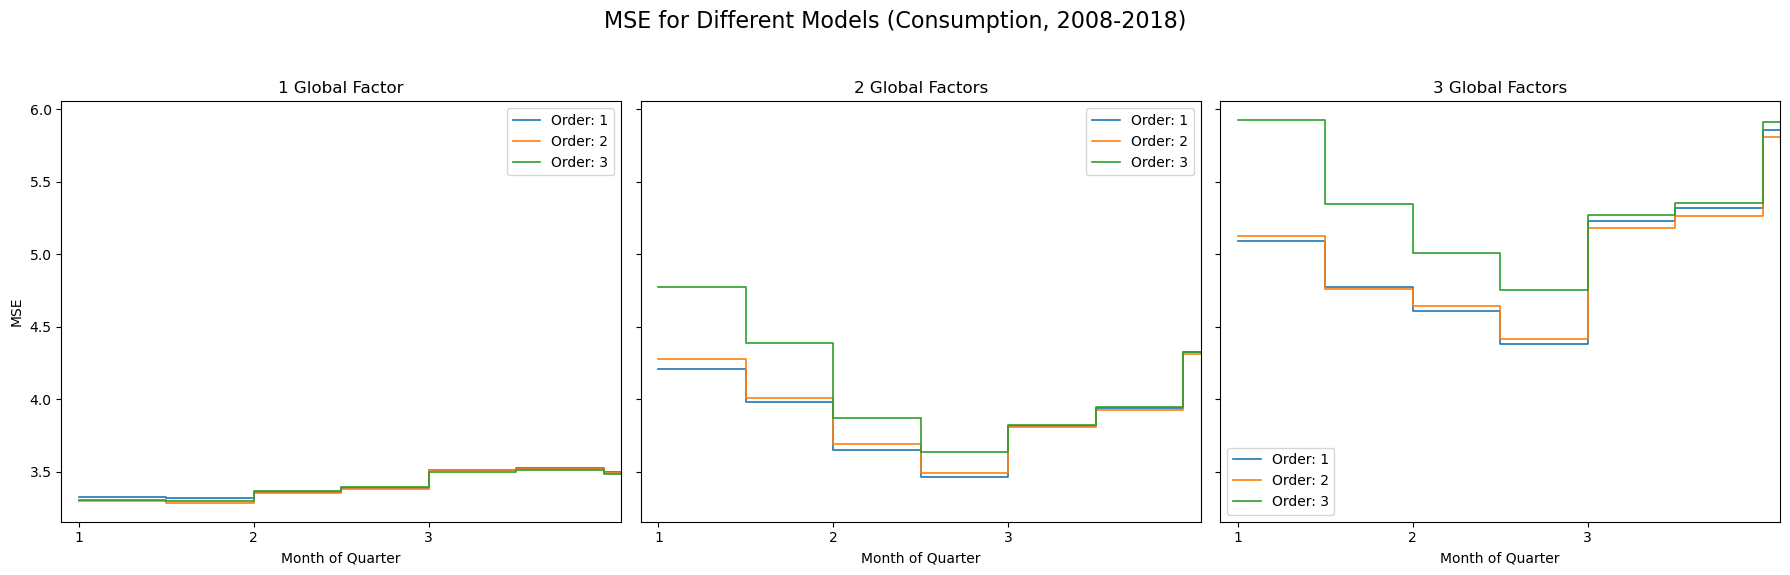

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


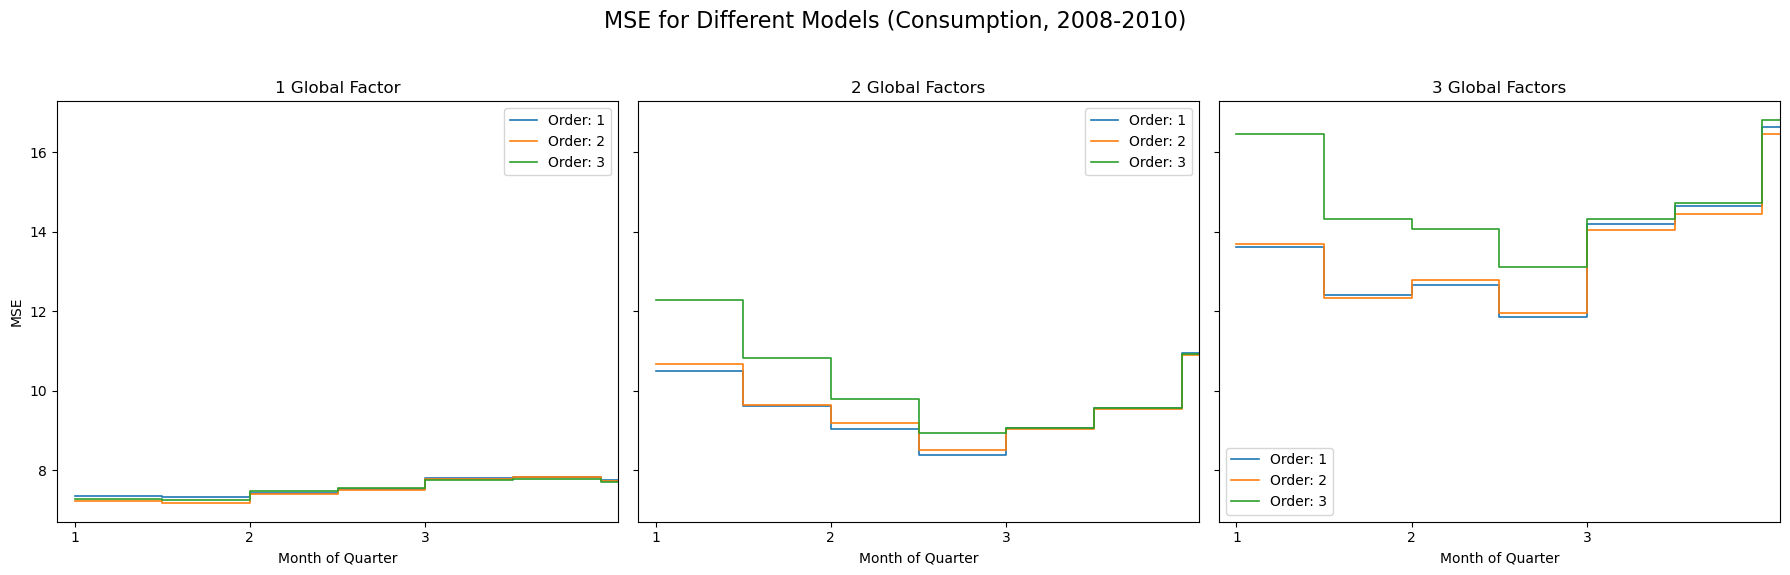

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


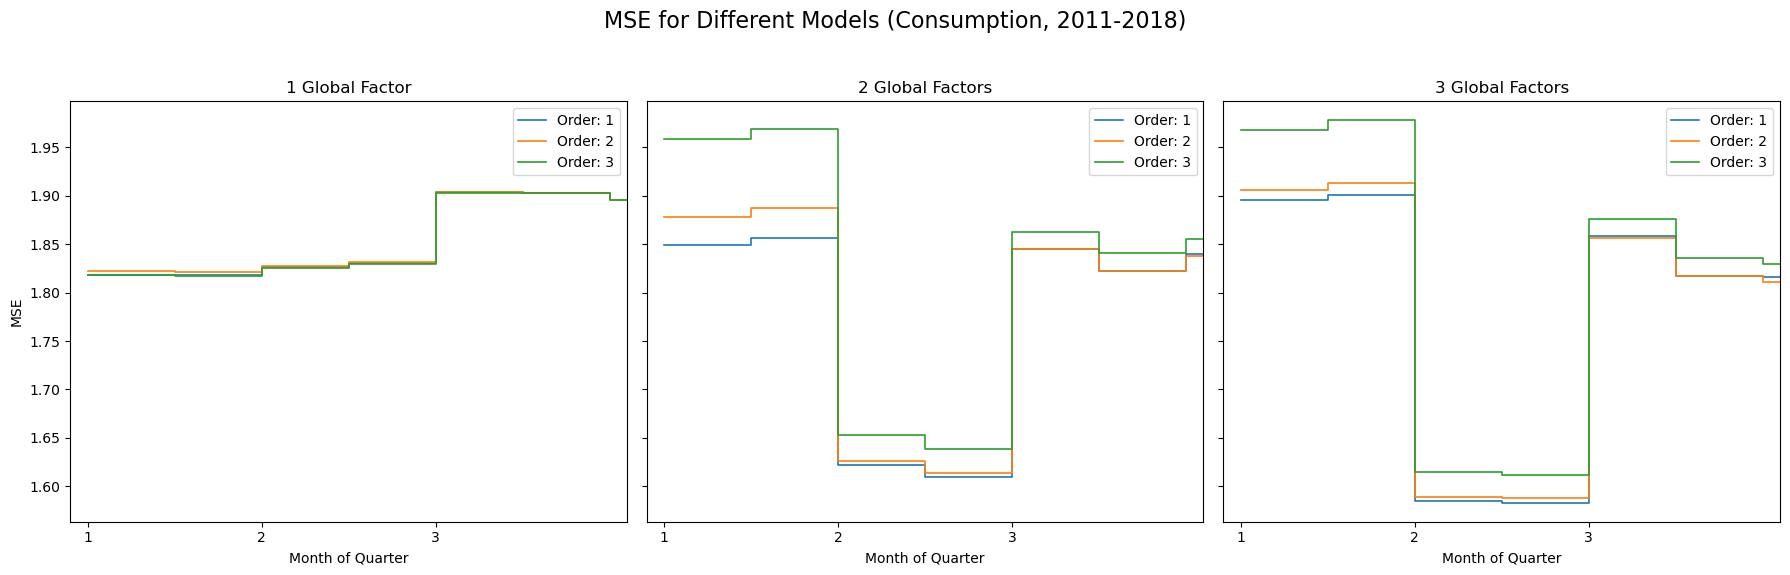

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


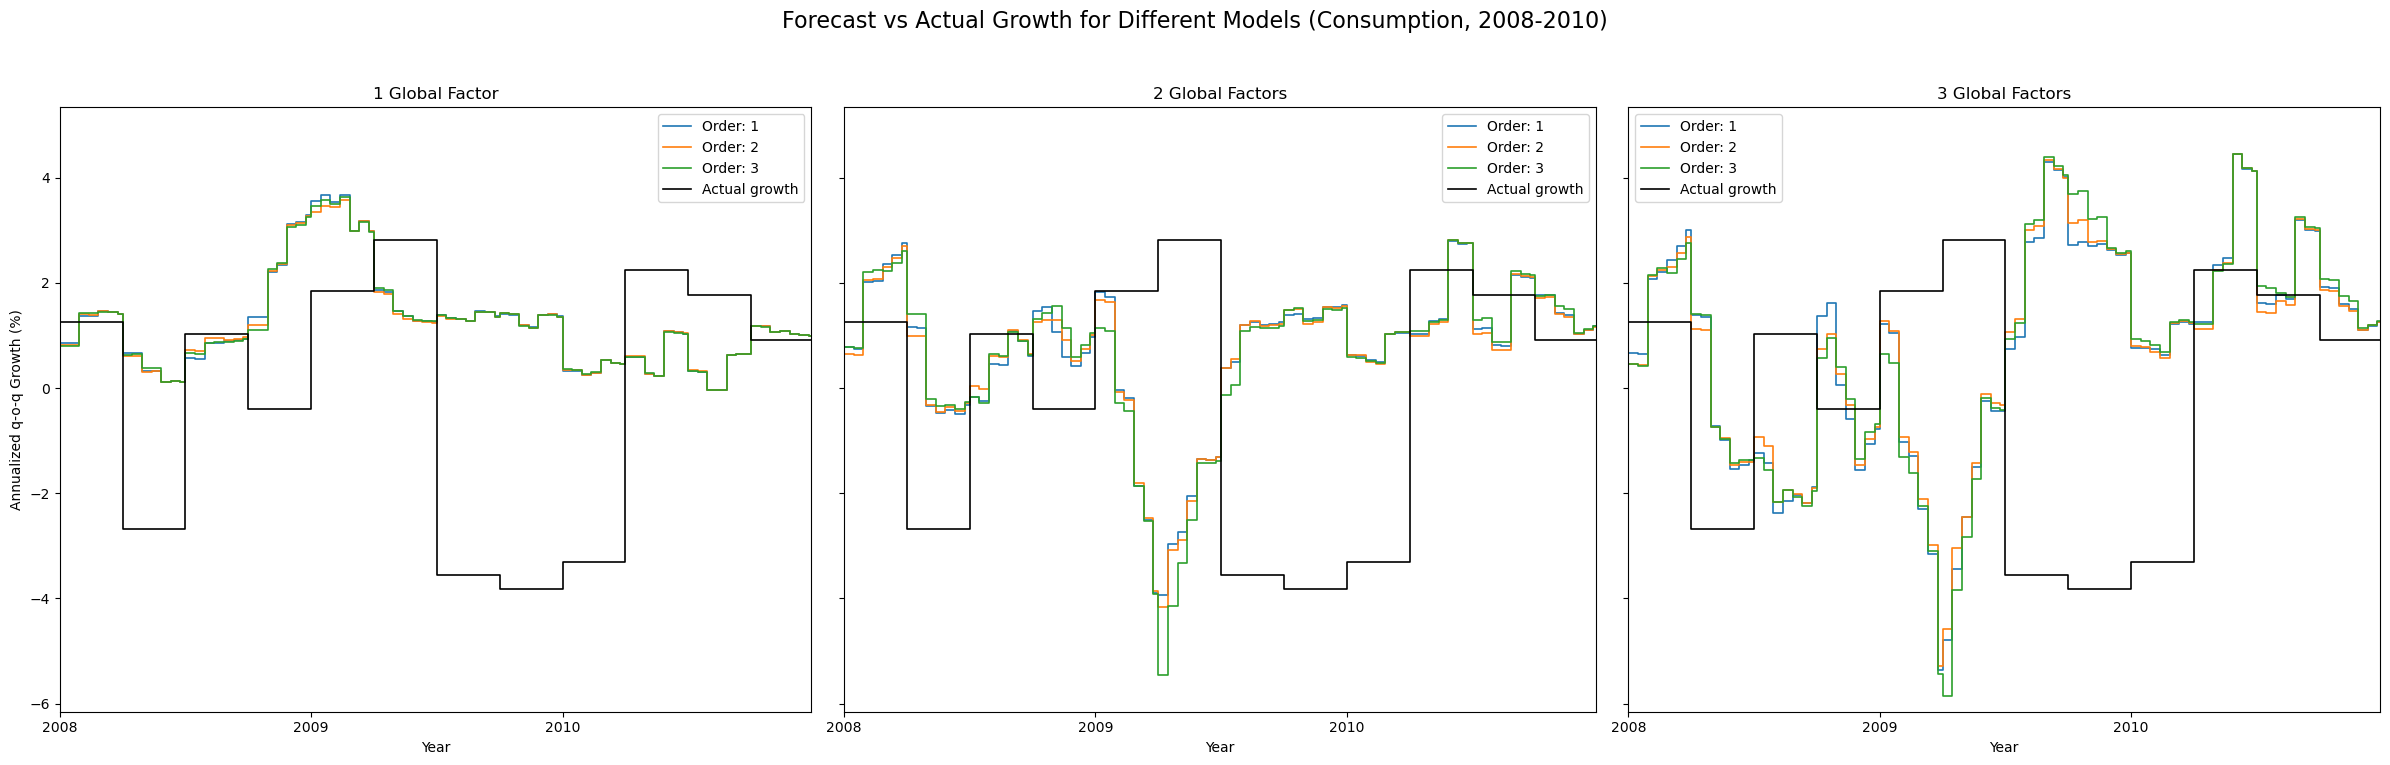

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


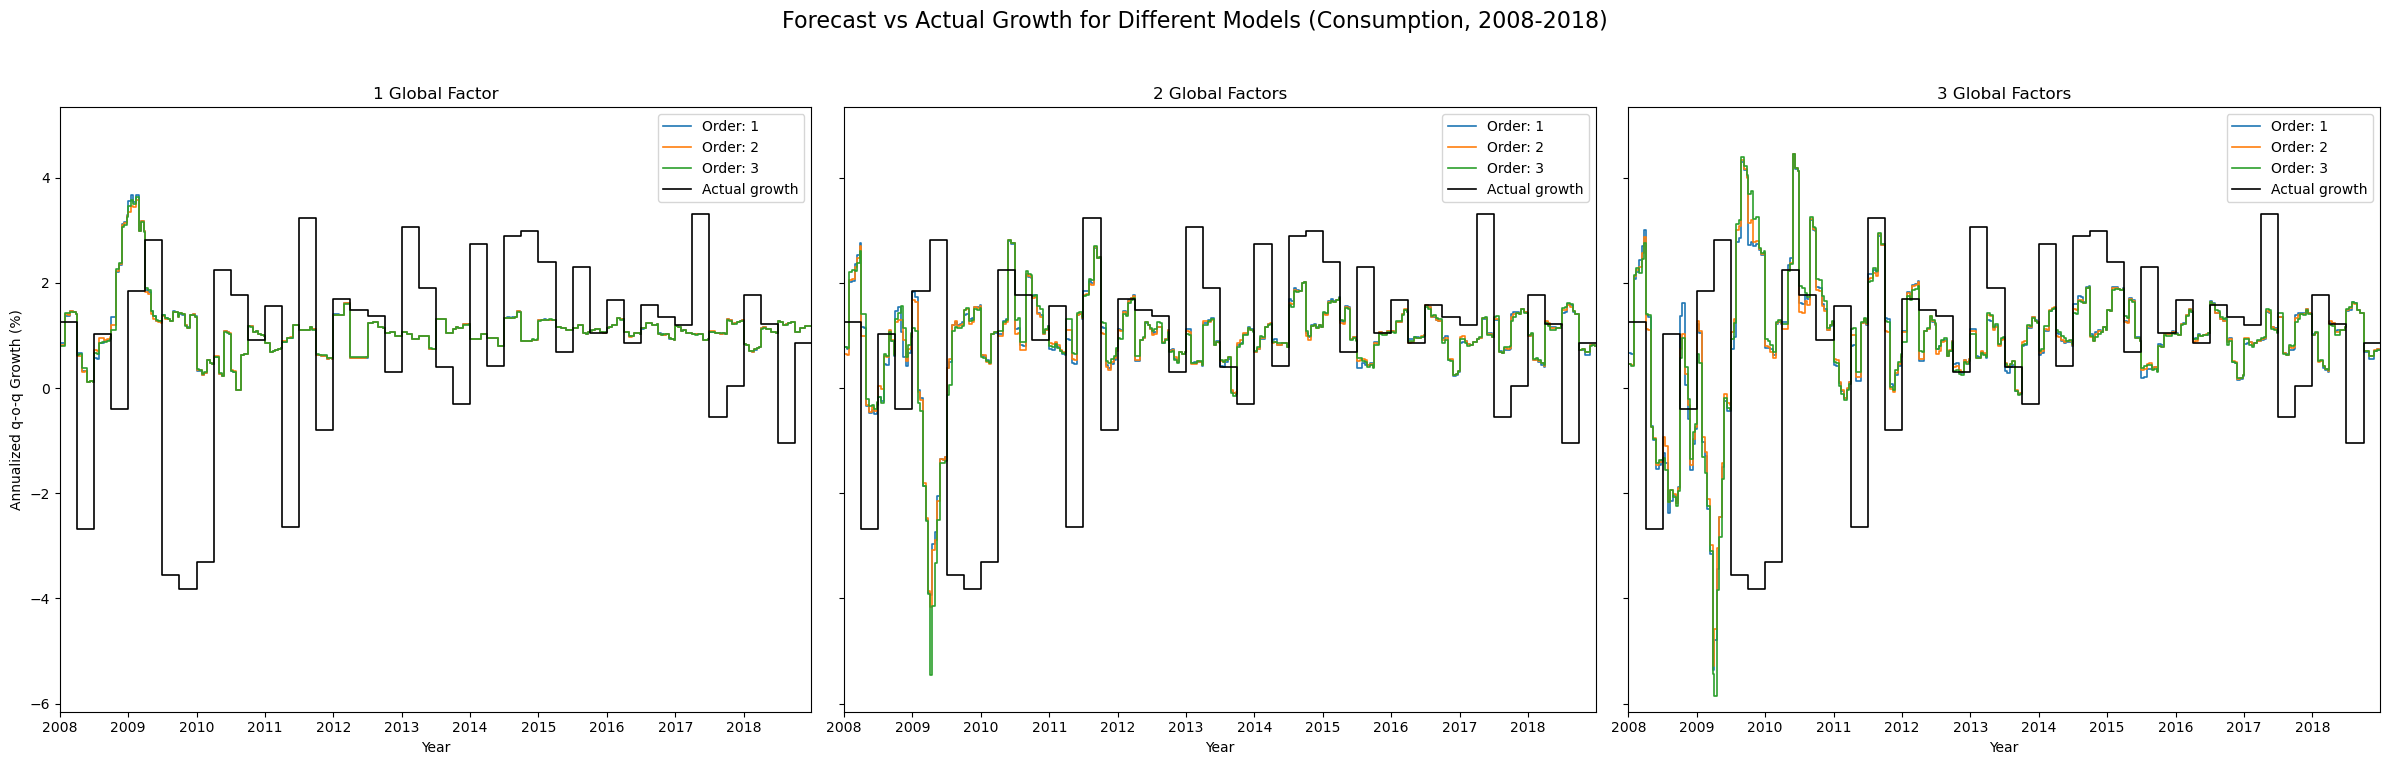

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


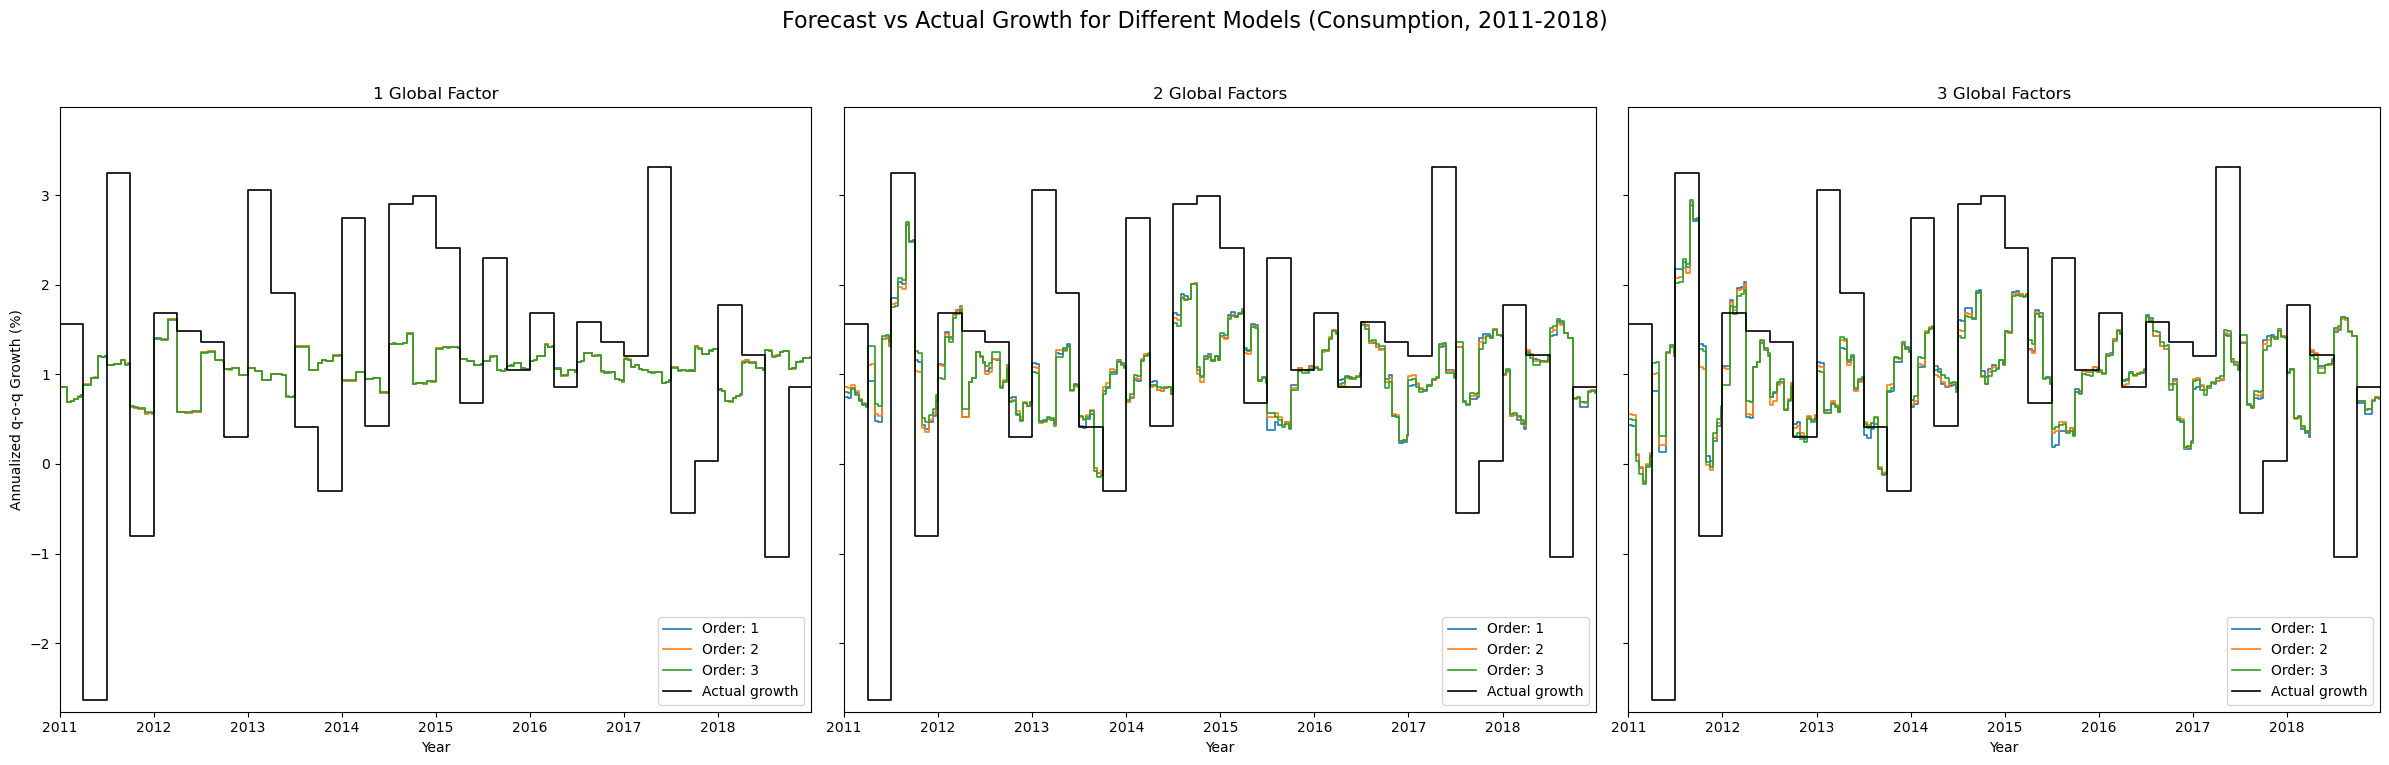

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = "_selected"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()